In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.10.0


In [2]:
# Create a list with the filepaths for training dataset
train_dir = Path("C:\\Users\\narma\\Desktop\\final\\dataset\\train")
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [3]:
# Create a list with the filepaths for testing dataset
test_dir = Path("C:\\Users\\narma\\Desktop\\final\\dataset\\test")
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
# Create a list with the filepaths for validation dataset
val_dir = Path("C:\\Users\\narma\\Desktop\\final\\dataset\\validation")
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [6]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['lettuce' 'spinach' 'cucumber' 'peas' 'beetroot' 'cabbage' 'cauliflower'
 'capsicum' 'kiwi' 'soy beans' 'turnip' 'tomato' 'corn' 'grapes'
 'pomegranate' 'raddish' 'apple' 'bell pepper' 'sweetcorn' 'carrot'
 'watermelon' 'potato' 'sweetpotato' 'pear' 'chilli pepper' 'onion'
 'pineapple' 'garlic' 'banana' 'lemon' 'paprika' 'mango' 'ginger'
 'eggplant' 'orange' 'jalepeno']


In [8]:
train_df.head(5)

,Filepath,Label
0,C:\Users\narma\Desktop\final\dataset\train\let...,lettuce
1,C:\Users\narma\Desktop\final\dataset\train\spi...,spinach
2,C:\Users\narma\Desktop\final\dataset\train\cuc...,cucumber
3,C:\Users\narma\Desktop\final\dataset\train\pea...,peas
4,C:\Users\narma\Desktop\final\dataset\train\bee...,beetroot


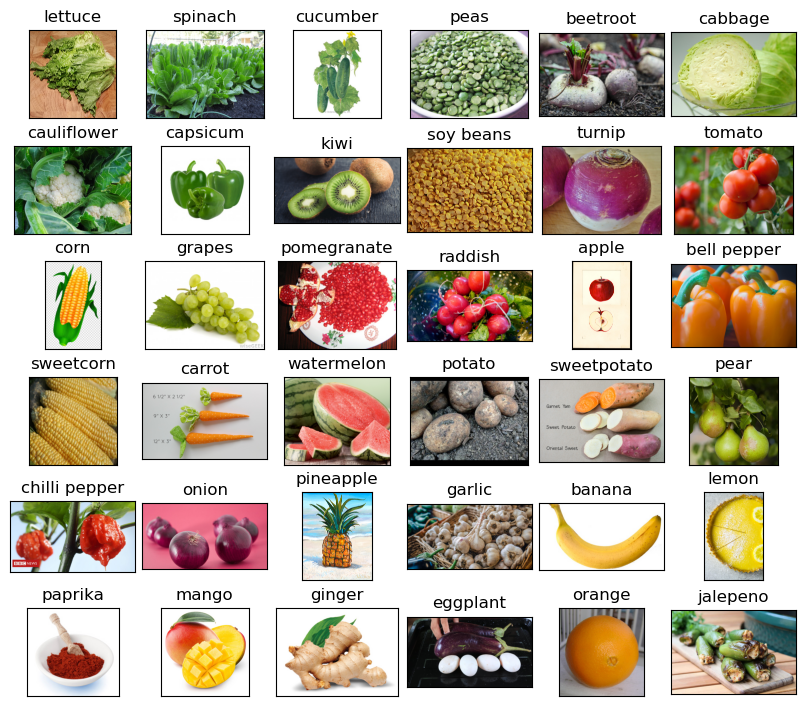

In [9]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display the pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [12]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 297s 3s/step - loss: 1.7558 - accuracy: 0.5384 - val_loss: 0.4566 - val_accuracy: 0.8529
Epoch 2/5
90/90 [==============================] - 272s 3s/step - loss: 0.5458 - accuracy: 0.8326 - val_loss: 0.2790 - val_accuracy: 0.9088
Epoch 3/5
90/90 [==============================] - 273s 3s/step - loss: 0.3408 - accuracy: 0.8886 - val_loss: 0.2521 - val_accuracy: 0.9294
Epoch 4/5
90/90 [==============================] - 279s 3s/step - loss: 0.2310 - accuracy: 0.9261 - val_loss: 0.1420 - val_accuracy: 0.9559
Epoch 5/5
90/90 [==============================] - 262s 3s/step - loss: 0.1453 - accuracy: 0.9545 - val_loss: 0.1407 - val_accuracy: 0.9588


In [16]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 29s 2s/step


['cabbage',
 'pomegranate',
 'turnip',
 'mango',
 'kiwi',
 'cauliflower',
 'beetroot',
 'chilli pepper',
 'bell pepper',
 'garlic',
 'garlic',
 'onion',
 'peas',
 'corn',
 'raddish',
 'potato',
 'spinach',
 'carrot',
 'cauliflower',
 'turnip',
 'corn',
 'pomegranate',
 'pineapple',
 'raddish',
 'ginger',
 'lemon',
 'watermelon',
 'bell pepper',
 'apple',
 'eggplant',
 'peas',
 'onion',
 'bell pepper',
 'paprika',
 'bell pepper',
 'apple',
 'carrot',
 'watermelon',
 'tomato',
 'mango',
 'pineapple',
 'lettuce',
 'jalepeno',
 'soy beans',
 'sweetcorn',
 'soy beans',
 'beetroot',
 'eggplant',
 'cabbage',
 'sweetpotato',
 'kiwi',
 'eggplant',
 'soy beans',
 'apple',
 'ginger',
 'potato',
 'capsicum',
 'pear',
 'lemon',
 'onion',
 'potato',
 'turnip',
 'pineapple',
 'spinach',
 'bell pepper',
 'bell pepper',
 'onion',
 'cucumber',
 'bell pepper',
 'grapes',
 'paprika',
 'watermelon',
 'turnip',
 'bell pepper',
 'turnip',
 'eggplant',
 'potato',
 'paprika',
 'turnip',
 'paprika',
 'cucumber'

In [17]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [18]:
img = output("C:\\Users\\narma\\Desktop\\final\\dataset\\train\\cabbage\\Image_81.jpg")
img

1/1 [==============================] - 2s 2s/step


'cabbage'

In [19]:
img = output("C:\\Users\\narma\\Desktop\\final\\dataset\\train\\eggplant\\Image_94.jpg")
img

1/1 [==============================] - 0s 78ms/step


'eggplant'

In [20]:
img = output("C:\\Users\\narma\\Desktop\\final\\dataset\\train\\carrot\\Image_12.jpg")
img

1/1 [==============================] - 0s 79ms/step


'carrot'

In [22]:
img = output("C:\\Users\\narma\\Desktop\\final\\dataset\\train\\watermelon\\Image_14.jpeg")
img

1/1 [==============================] - 0s 63ms/step


'watermelon'

In [23]:
img = output("C:\\Users\\narma\\Desktop\\final\\dataset\\train\\pomegranate\\Image_11.jpg")
img

1/1 [==============================] - 0s 63ms/step


'pomegranate'

In [24]:
model.save('FV.h5')